# Reduce skew data

Map/Reduce is often used to compute statistics on words. For example, you want to study the sentance from Wikipedia containing a specific word or let's say compute the length distribution of all sentance including a specific word $w$. The map/reduce job would look lihe this:

- consider the data set A which contains all the pages from Wikipedia
- split every page into sentances
- split every sentance into words, emit three columns: word, length(sentance)
- reduce on word, compute the distribution of the sentance length for each word, emit two columns: word, histogram of sentance length

Globally, the total cost of the job is $O(N_w)$ where $N_w$ is the total number of words. Wikipedia might contain several billions of words. That process could be easily processed on a single machine. However, let's assume now, instead of computing the distribution of the sentance length, we would like to apply a much heavier process. For example, we could consider the set of all sentance including a word $w$ and try to guess the different meaning of this word. For example, we could try to guess the number of different [meanings of a word](https://en.wikipedia.org/wiki/Word-sense_induction) based on a clustering of co-occurrence matrix: $M_w(w_i,w_j)=$ _number of times the words_ $w,w_i,w_j$ _appear in a same sentance_. Let's consider the following jobs:

- consider the data set A which contains columns $w,sentance$
- for all rows, for all pair of words $(w_1 \neq w_2)$, emit $w,w_1,w_2$
- reduce on $w,w_1,w_2,n$ where $n$ is the number of rows sharing the same triplet $w,w_1,w_2$
- reduce on $w$, cluster the matrix build from all rows sharing the same $w$, emits the most common word of each cluster

The last step is the longest one. The goad is not to implement a clustering algorithm but to study what happen is the data set is skewed. So to summarize, the last step applies a complex method of cost $O(f(n))$ for each word $w$ and $n$ is somehow related to the number of sentances $n(w)$ containing that word. The total cost of the last step will be: $\propto C=\sum_w f(n(w))$. We also defined $N=\sum_w n(w)$ which is simply the number of observations of the data set.

When dealing with words, we often observe that any count distribution follows a random law close to a [Zipf's law](https://en.wikipedia.org/wiki/Zipf's_law). In other terms, it means that: 

$$P(n(w)=i)=\frac{K}{i^s} \text{ with } K=\sum_i i^{-s} \text{ and } s>1$$

This way, $N = K\sum_i i^{1-s}$. The Zipf's law is just an assumption on how these observations will be aggregated against the key used to reduce the data set.

Let's see an example:

In [1]:
%matplotlib inline

[1 1 1 2 2 2 1 1 1 1 1 2 2 1 1 3 1 1 1 1]


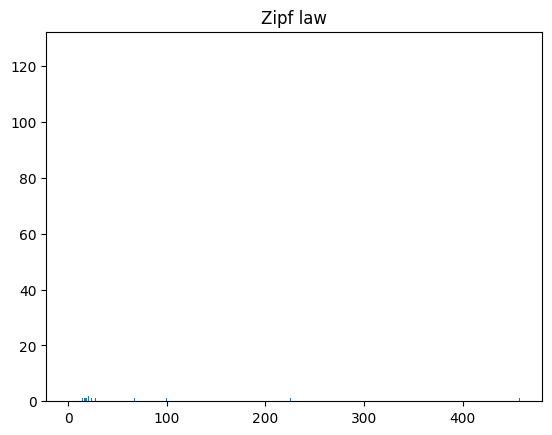

In [2]:
from numpy.random import zipf
from numpy import histogram
import matplotlib.pyplot as plt

v = zipf(2, 20)
print(v)
v = zipf(2, 200)
hist = histogram(v, bins=range(1, max(v) + 1))
plt.bar(hist[1][:-1], hist[0])
plt.title("Zipf law");

Usually, we use logarithmic scale on both sides, otherwise the plots often shows a white square.

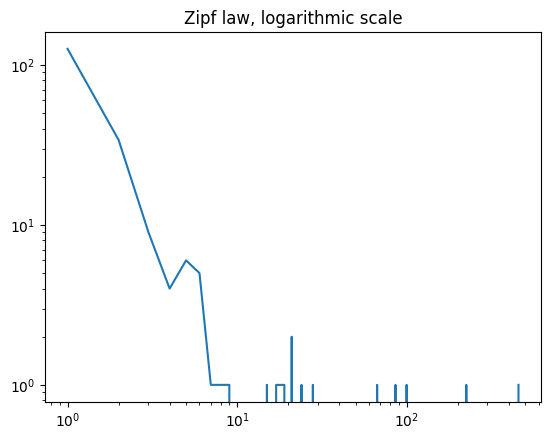

In [3]:
plt.loglog(hist[1][:-1], hist[0])
plt.title("Zipf law, logarithmic scale");

Now, we try different $s$:

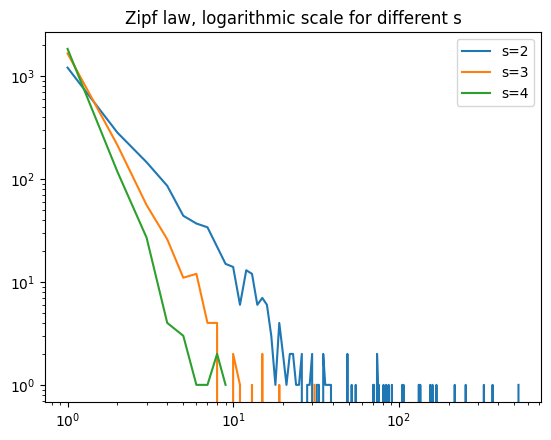

In [4]:
from numpy.random import zipf
from numpy import histogram

for s in [2, 3, 4]:
    v = zipf(s, 2000)
    h = histogram(v, bins=range(1, max(v) + 1))
    plt.loglog(h[1][:-1], h[0], label="s=%1.0f" % s)
plt.legend()
plt.title("Zipf law, logarithmic scale for different s");

What about the cost $C$ of the last step of the map/reduce job if the key $w$ we reduce on follows a Zipf's law? We can express it as follows:

$$C= K \sum_i \frac{f(i)}{i^s}$$

The cost $f(i)$ is usually polynomial: $f(i) \propto i^t$. Then $C \propto \sum_i i^{t-s}$. This sum can be computed only if $t<s-1$. 

**What does it means?**

When you run a reduce step, if you know in advance the distribution of the number of observations $n(w)$ accumulated on key $w$, it is easy to have an estimation of the total time your job will need to complete. However, it is often unknown. All we usually know is the total number of observations. But how it is distributed over the key, it is usually unknown. If the function $f(i)$ is linear, the cost will be proportional to $N$ the number of observations. If $f(n)$ is not linear, we can try to estimate by making on assumption on $n(w)$: it follows a Zipf's law. In that case, we would like to know how long it will take for the biggest key to be processed. The biggest key is the key shared by the highest number of observations: $w^* = \arg\max_w n(w)$. So we are interested in:

$$P\left(n(w^*)=i | \sum_w n(w)=N\right) \text{ with } n(w) \sim Zipf(s)$$

We want to know how much data will be aggregated with the same key, is it 10%, 20%, 50%? The higher it is, the most difficult is will be to distribute the task over many machines. For example, if 50% of the data is accumulated on one key, it means a machine will have to process 50% of the data set all by itself. That is a very skewed data set.

At this stage, I'm going to take a short cut. I'll simulate the ratio $\frac{n(w^*)}{\sum_w n(w)}$ for a fix number of keys.

In [5]:
N = 1000
serie = []
for s in [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]:
    print(s)
    for i in range(0, 1000):
        v = zipf(s, N)
        m = max(v)
        t = sum(v)
        r = m / t
        serie.append((s, r))

2.0
2.5
3.0
3.5
4.0
4.5
5


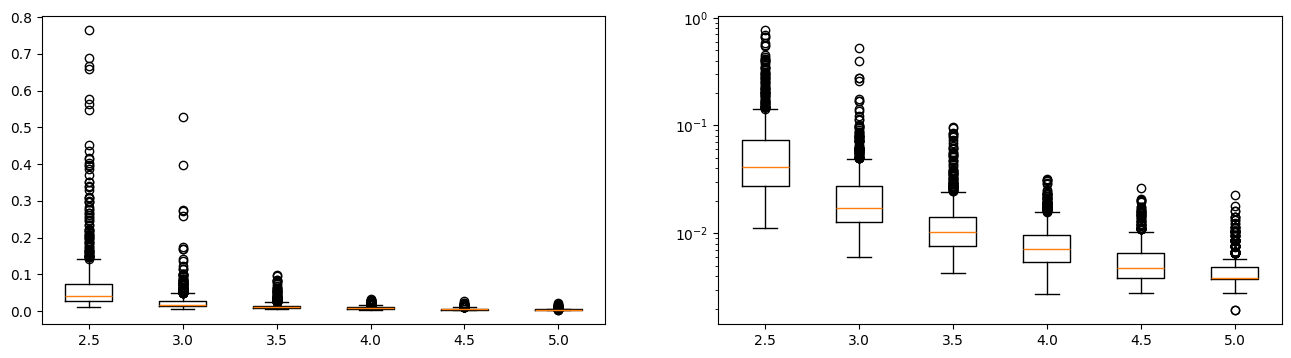

In [9]:
xt = sorted(set(__[0] for __ in serie))[1:]
data = [[_[1] for _ in serie if _[0] == s] for s in xt]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].boxplot(data)
ax[0].set_xticks(range(1, len(xt) + 1), ["%1.1f" % _ for _ in xt])
ax[1].boxplot(data)
ax[1].set_xticks(range(1, len(xt) + 1), ["%1.1f" % _ for _ in xt])
ax[1].set_yscale("log");

This ratio can reach very high values as $s \rightarrow 2$. Below 2, the sum $\sum_w n(w)$ does not exist. When you process text data, it often happens that 10% of the data shares the same key. It means most of time a map/reduce jobs distributes the work over many machines and one of them is still working when all the other are done. Just because one key represents 10% of the data set.

Text is tricky, [17% of English words start by t](https://en.wikipedia.org/wiki/Letter_frequency). Graphs are also a good example. The web is considered as a [scale-free network](https://en.wikipedia.org/wiki/Scale-free_network). It is nearly impossible to break a connected component by cutting an edge and the degree distribution follows a [power law](https://en.wikipedia.org/wiki/Power_law). As a result, joining a set of edges against itself is always a challenge as it is very often that a key (= a vertex) is shared by a huge amount of edges (= the vertex is connected to many of them). These big vertices are called "hub". Depending on what you need to compute on the graph, you might prune some edges or even remove the hubs (see [Small-world phenomenon](https://en.wikipedia.org/wiki/Small-world_phenomenon)).